In [1]:
#%% import libraries
import os
import glob
import numpy as np

from scipy.spatial.distance import euclidean
from scipy import signal
from peakdetect import peakdetect
from scipy.signal import savgol_filter

import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

plt.style.use('default')
plt.rcParams['axes.grid'] = True
plt.rcParams["figure.figsize"] = (16, 3.5)
plt.rcParams['figure.dpi'] = 150

import warnings
warnings.filterwarnings('ignore')


#%% functions
def peak_detection(array, look_ahead=500, diff_threshold=0.01):
    # lookahead is the distance to look ahead from a peak to determine if it is the actual peak.
    peaks = peakdetect(array, lookahead=look_ahead, delta=diff_threshold)
    higherPeaks = np.array(peaks[0])
    lowerPeaks = np.array(peaks[1])

    peak_lists_ = np.concatenate([higherPeaks[:, 0], lowerPeaks[:, 0]], axis=0)

    return peak_lists_

def change_slope_detection(array, window=500, poly=3, deriv=3):
    der2 = savgol_filter(array, window_length=window, polyorder=poly, deriv=deriv)
    max_der2 = np.max(np.abs(der2))
    large = np.where(np.abs(der2) > max_der2/2)[0]
    gaps = np.diff(large) > window
    begins = np.insert(large[1:][gaps], 0, large[0])
    ends = np.append(large[:-1][gaps], large[-1])
    changes = ((begins+ends)/2).astype(np.int32)
    
    return changes

def butter_highpass(cut=0.5, order=5):
    b, a = signal.butter(order, cut, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cut, order=5):
    b, a = butter_highpass(cut, order=order)
    y = signal.filtfilt(b, a, data, axis=0)
    return y

In [2]:
#%% Read data
path_to_dataset = '/Users/hoanglinh/Library/CloudStorage/OneDrive-NTHU/Projects and Papers/ASE_PHM_WireBonding/dataset'
data_date = '10_DAQ_20221227'
folder_path = os.path.join(path_to_dataset, data_date)
program = os.listdir(folder_path)
program.remove('.DS_Store')
program.remove('Set_Parameter.xlsx')

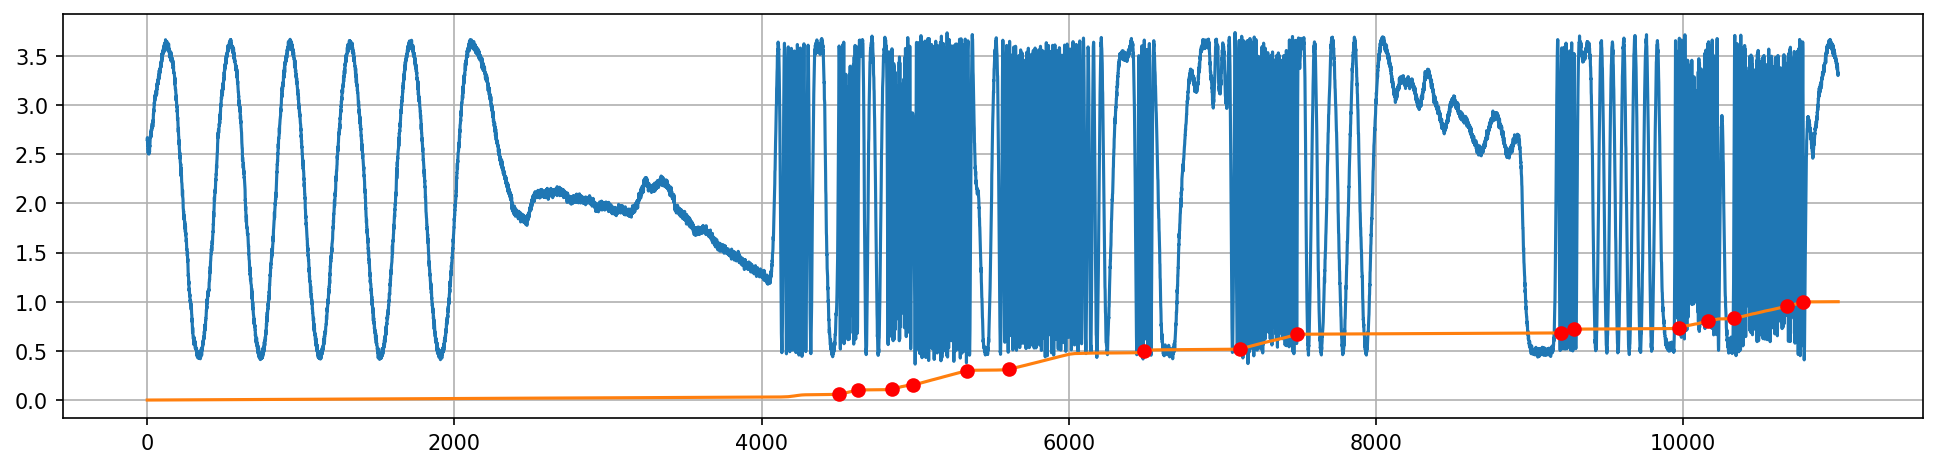

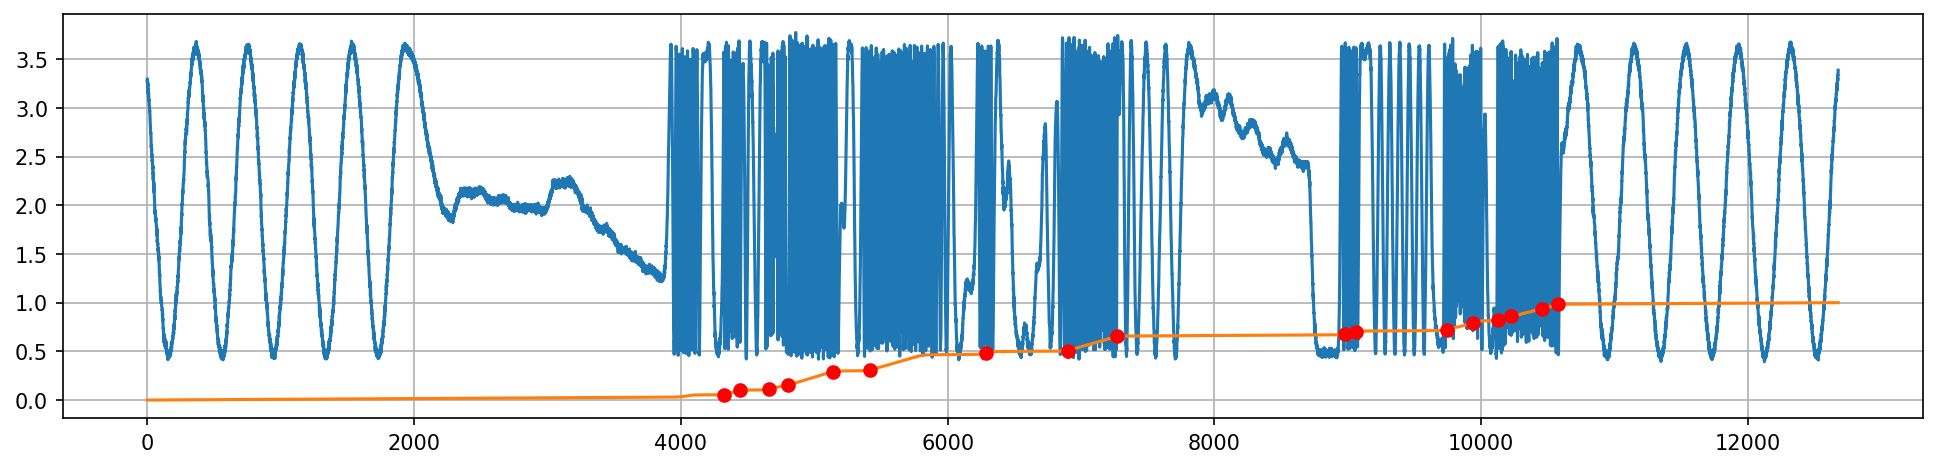

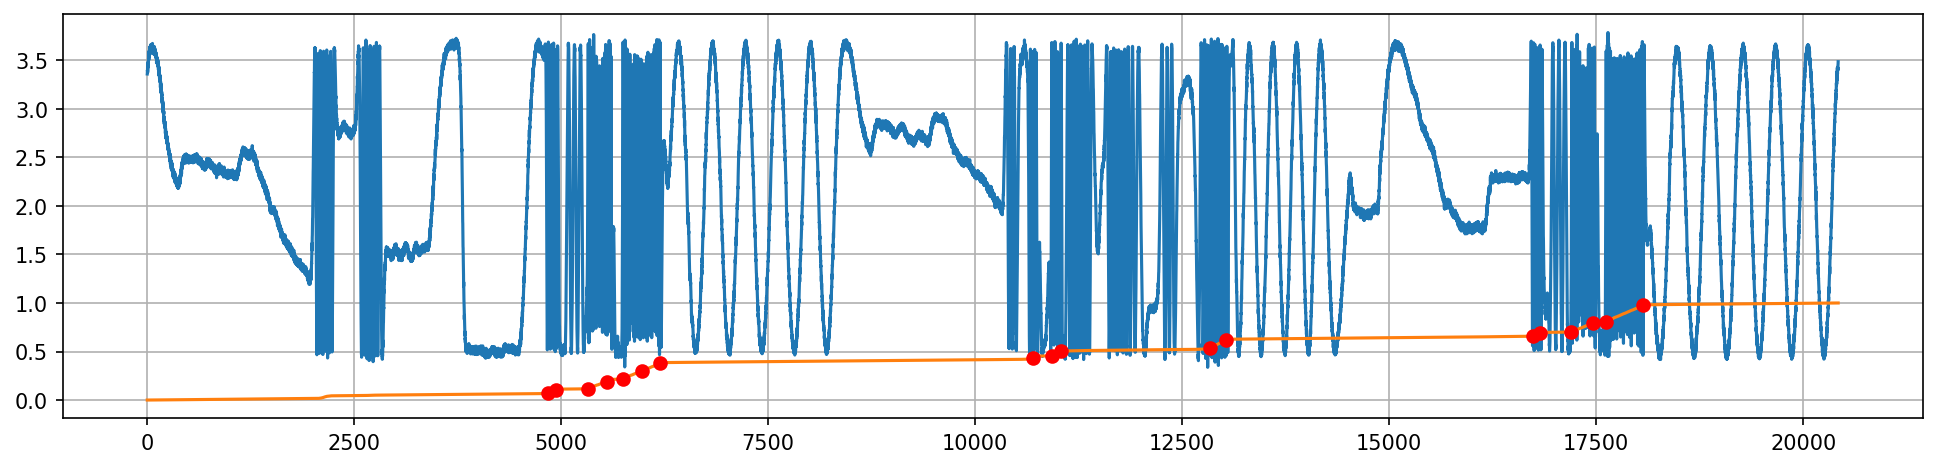

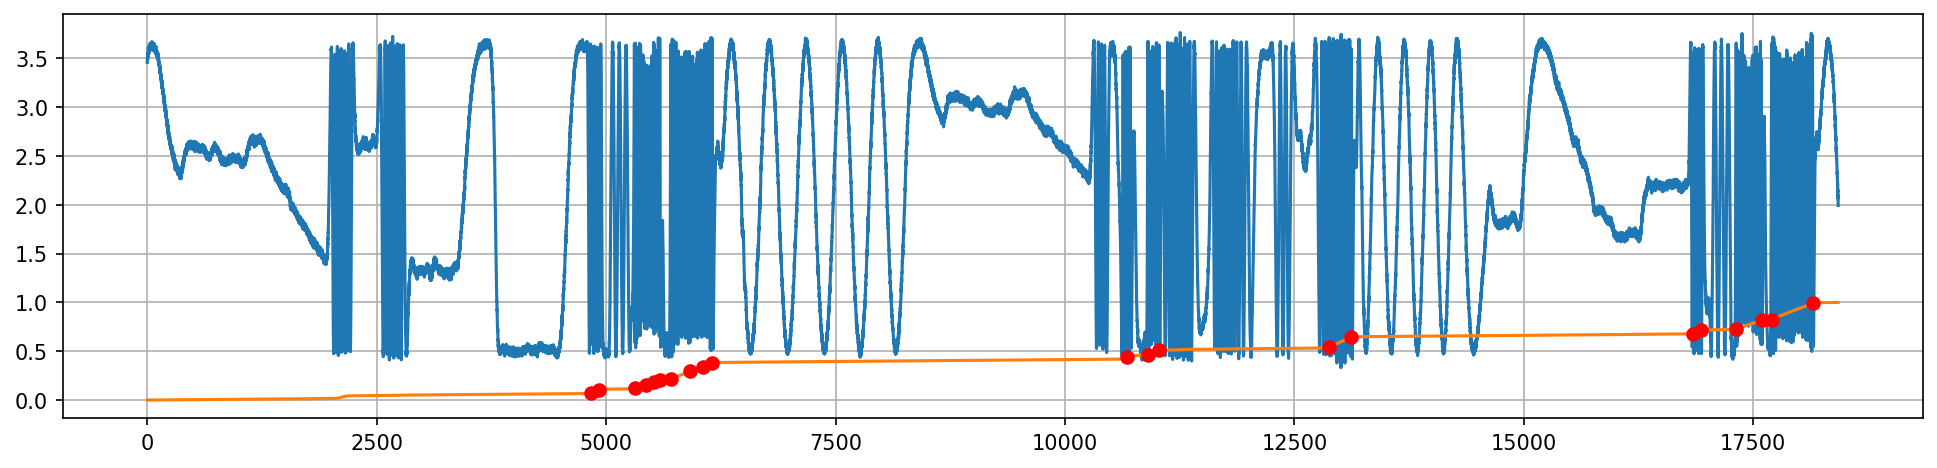

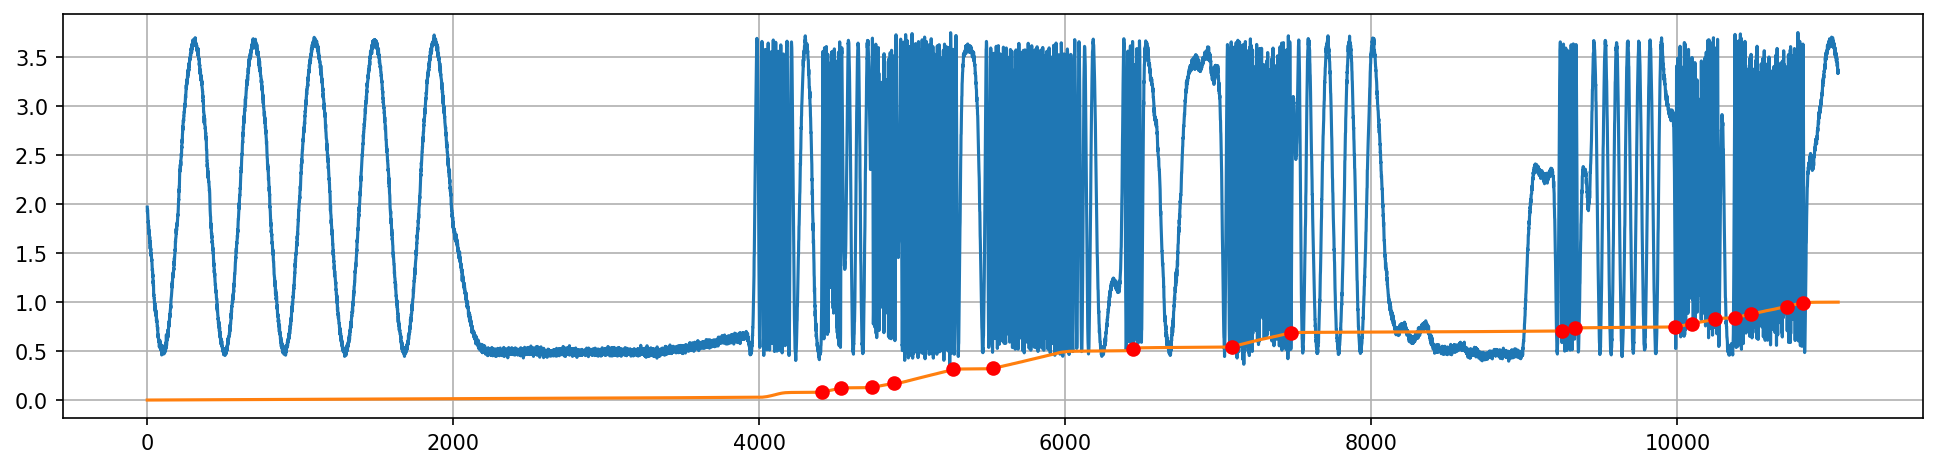

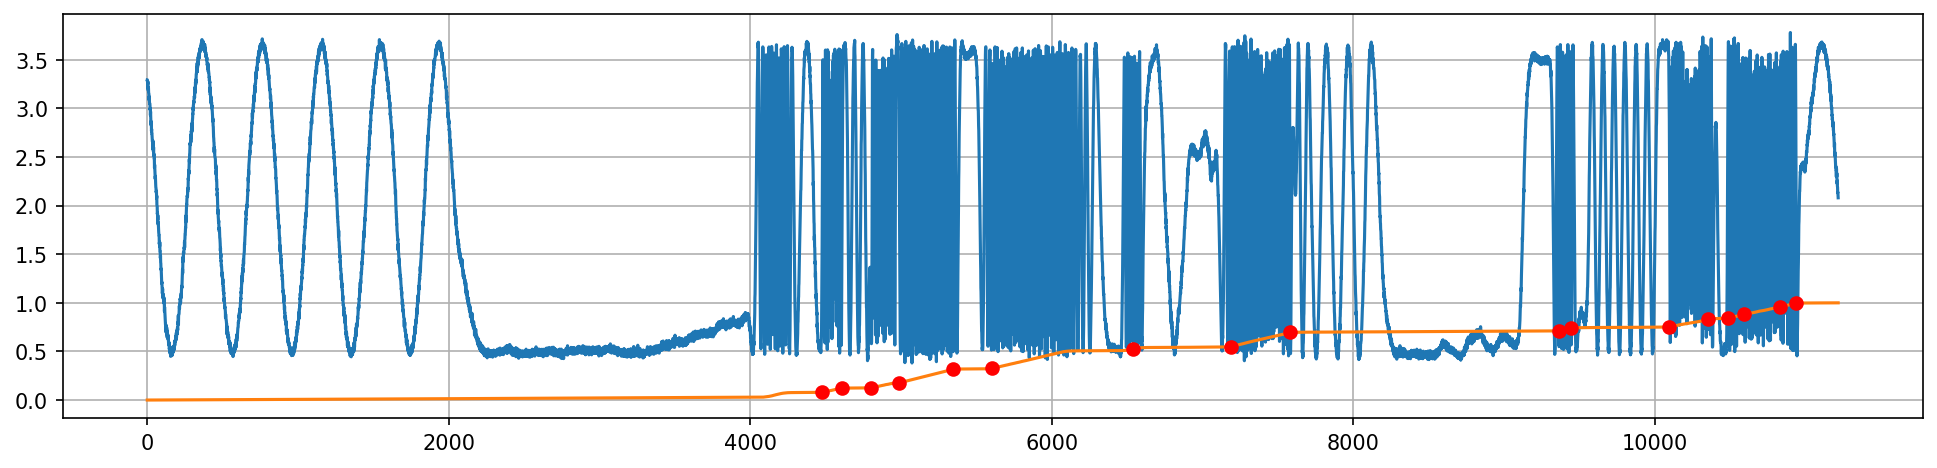

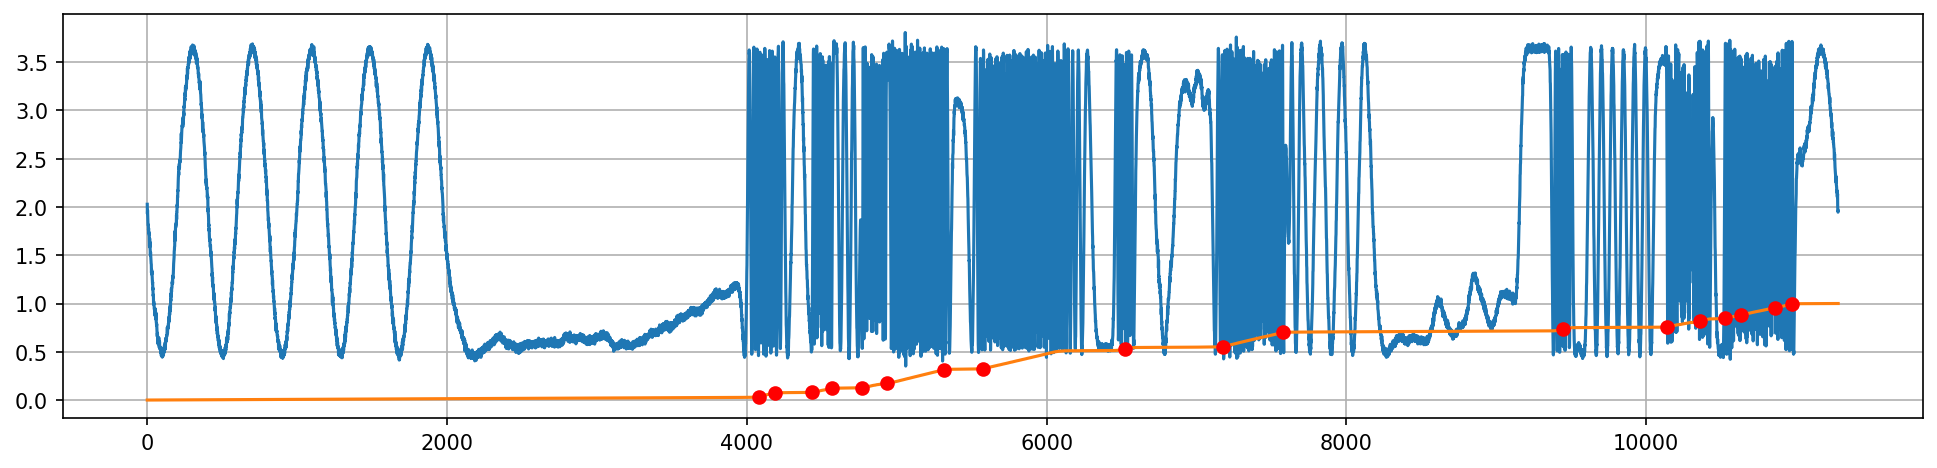

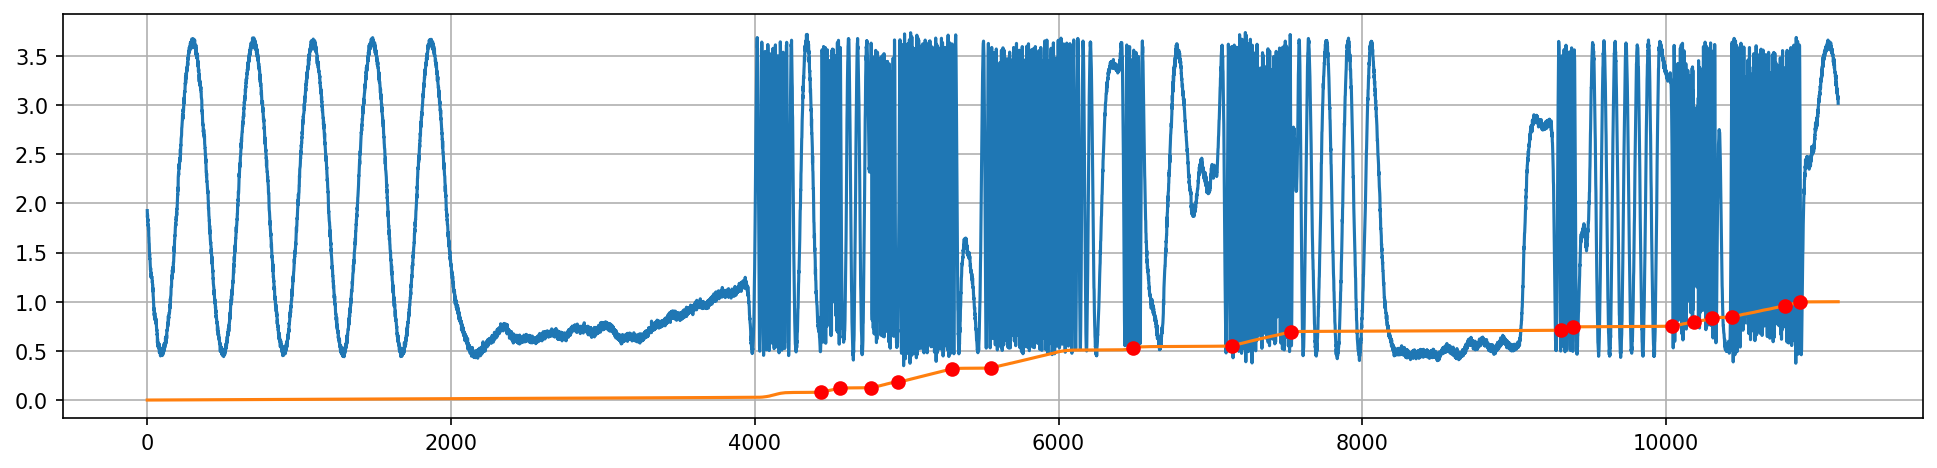

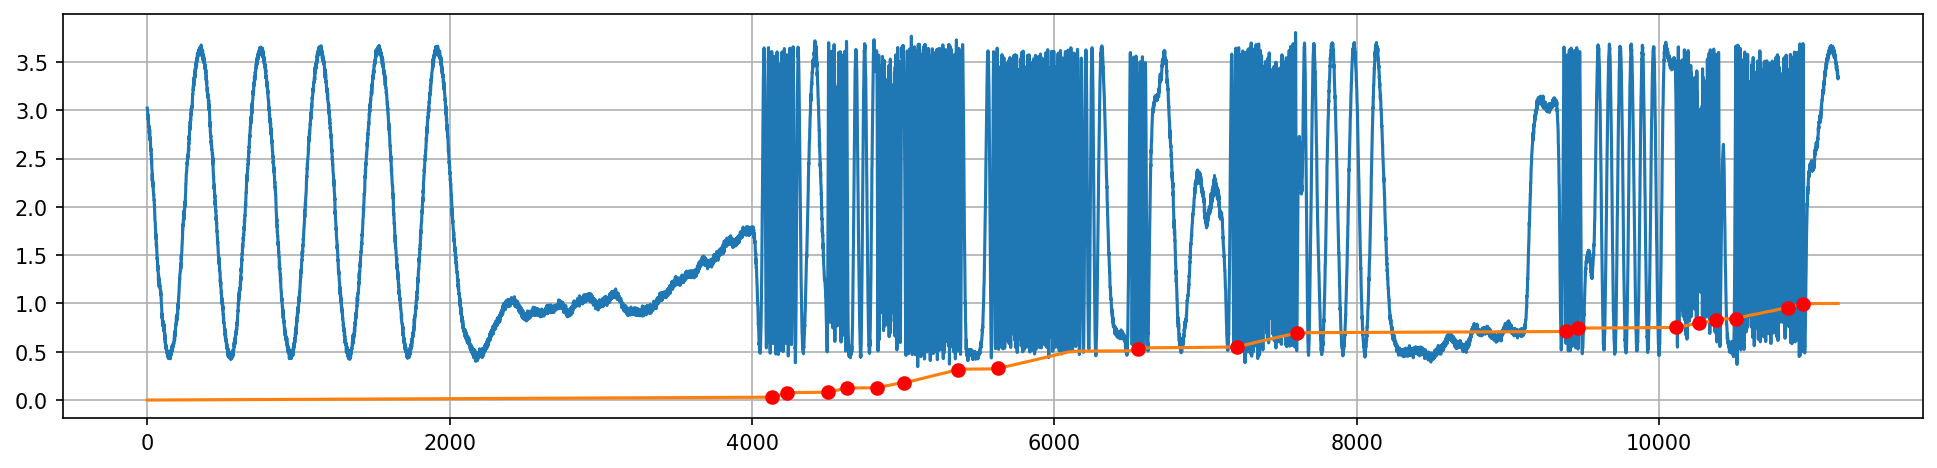

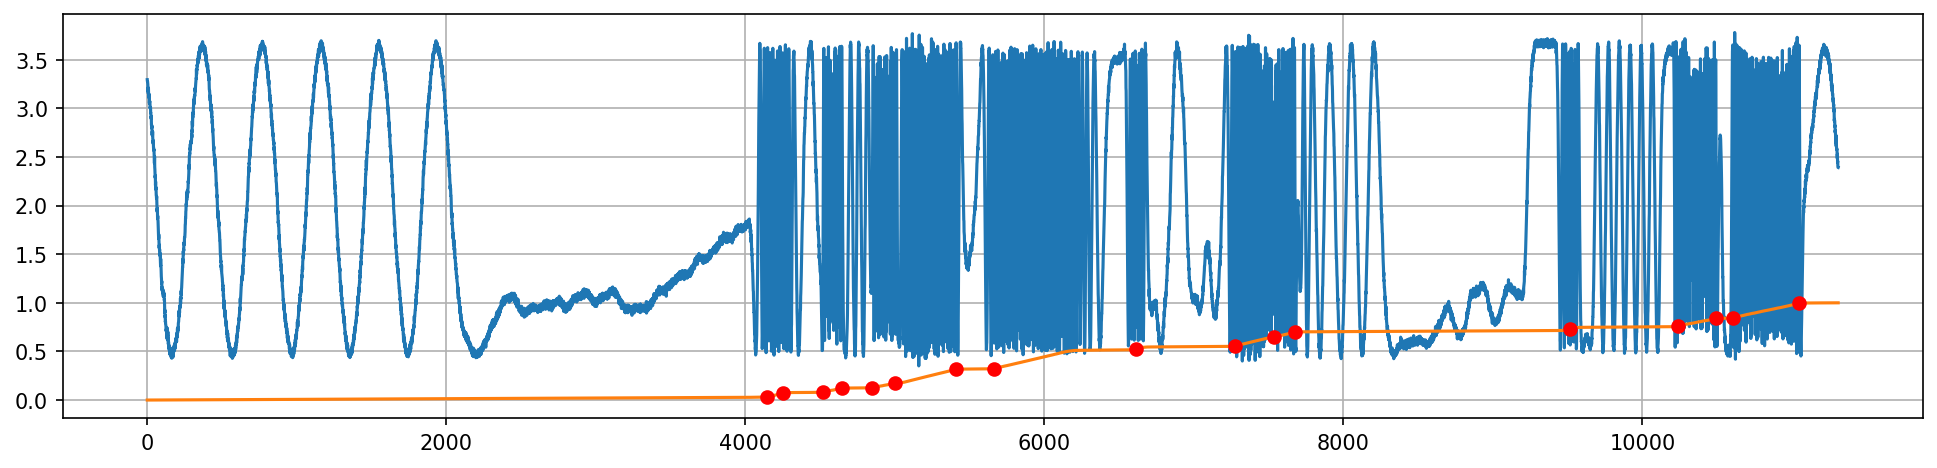

In [8]:
#%% Start crop
for program_folder in program:
    program_csv = os.path.join(folder_path, program_folder, 'One_Die')
    csv_files = glob.glob(os.path.join(program_csv, "*.csv"))
    
    ls = []
    for csv_file in csv_files:
        ls.append(pd.read_csv(csv_file, header=None, index_col=None).drop([0, 1, 2, 5], axis=1))
    all_csv = pd.concat(ls, ignore_index=True)
    all_csv.columns = ['Z', 'Piezo']

    #%% using cumsum method and detect change slope locations
    crop_idx, dary_list = [], []

    dary = all_csv['Piezo'].copy().rolling(window=200, min_periods=1).mean()
    dary -= np.average(dary)

    #%% using cumsum method
    dary_step = np.cumsum(dary)
    dary_step = (dary_step - dary_step.min()) / (dary_step.max() - dary_step.min())
    # crop_idx = change_slope_detection(dary_step, 500, 2, 2)
    crop_idx = peak_detection(dary_step)
    
    # insert 0 and end points
    crop_idx = np.insert(crop_idx, [0, crop_idx.shape[0]], [0, crop_idx.shape[0]])
    
    #%% create crop pair instead of just cutting indices
    crop_idx_pair = []
    for idx, val in enumerate(crop_idx):
        try:
            crop_idx_pair.append([val, crop_idx[idx+1]])
        except IndexError:
            pass

    crop_idx_pair = np.array(crop_idx_pair, dtype=int)
    
    #%% crop for 1st bond, looping and 2nd bond
    # TODO: detect looping part and ignore them
    
    for idx, crop_interval in enumerate(crop_idx_pair, start=1):

        df_z_sample = all_csv['Z'][crop_interval[0]: crop_interval[1]].values
        z_normalize = abs(butter_highpass_filter(data=df_z_sample, cut=0.1, order=10))

        dary_step_normalized = np.cumsum(z_normalize)
        dary_step_normalized = (dary_step_normalized - dary_step_normalized.min()) / (dary_step_normalized.max() - dary_step_normalized.min())
        
        # TODO: how to choose change_detection method?
        change_for_an_interval = change_slope_detection(dary_step_normalized, window=50, poly=2, deriv=2)
        plt.plot(df_z_sample)
        plt.plot(dary_step_normalized)
        plt.plot(change_for_an_interval, dary_step_normalized[change_for_an_interval], 'ro')
        plt.show()
        
        if idx == 10: break
        
    break
        

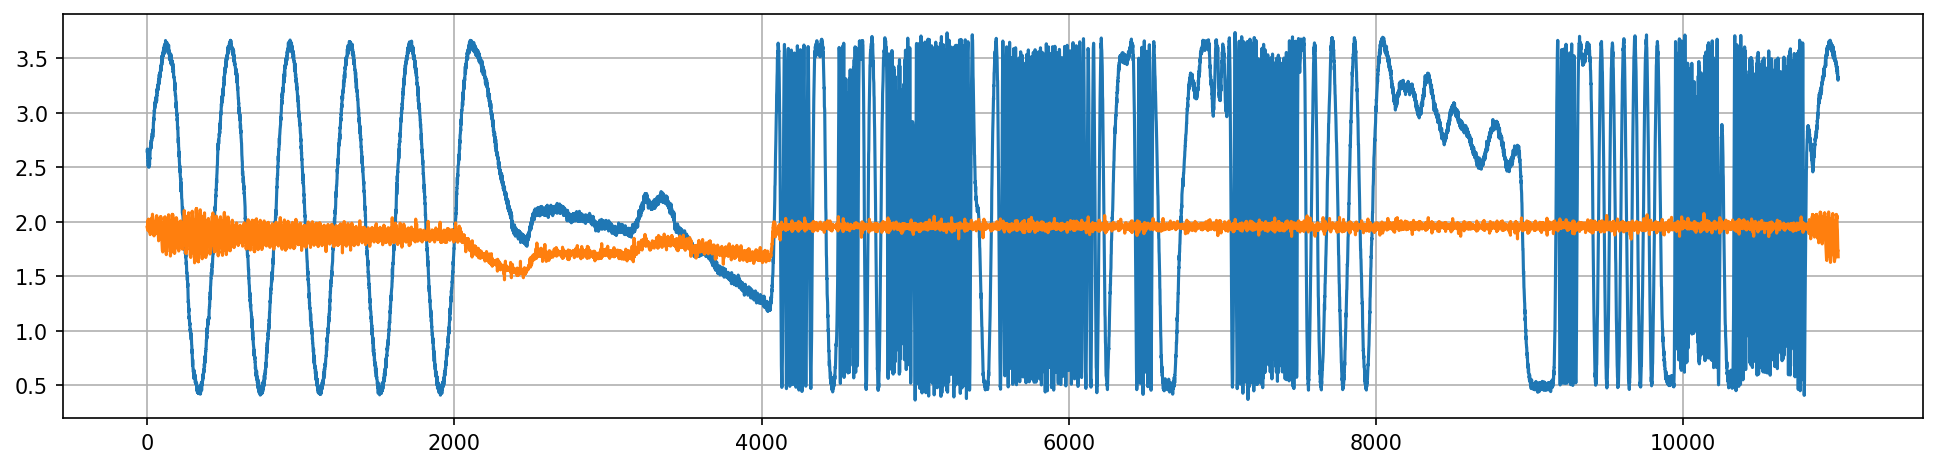

In [5]:
plt.plot(all_csv[crop_idx_pair[0][0]: crop_idx_pair[0][1]])